# Introduction

**In this lecture, we will learn**
- what digital images are,
- how images are acquired and formed,
- basics of image sampling and quantization,
- what histogram is and how to compute it.

**The lecture is based on**
- [\[Burger22\] Wilhelm Burger, Mark J. Burge: *Digital Image Processing: An Algorithmic Introduction (3rd edition)*](https://imagingbook.com/books/english-edition-hardcover/)  
  Chapter 1 "Digital images"  
  Chapter 2 "Histograms and Image Statistics"
- [\[Gonzalez18\] Rafael C. Gonzalez, Richard E. Woods. *Digital Image Processing (4th edition)*](https://www.imageprocessingplace.com/)  
  Chapter 1 "Introduction"  
  Chapter 2 "Digital Image Fundamentals"
- [\[Mazet24\] Vincent Mazet: *Basics of Image Processing*](https://vincmazet.github.io/bip/digital-images/intro.html)  
  Chapter "Digital images"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import skimage

# Basic terms

> **Signal processing** is an electrical engineering subfield that focuses on analyzing, modifying and synthesizing signals, such as sound, images, potential fields, seismic signals, altimetry processing, and scientific measurements.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Signal_processing) 

> **Digital image processing** is the use of a digital computer to process digital images through an algorithm. It is a subcategory or field of digital signal processing.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Digital_image_processing)

> **Image analysis** or imagery analysis is the extraction of meaningful information from images; mainly from digital images by means of digital image processing techniques.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Image_analysis) 

> **Computer vision** tasks include methods for acquiring, processing, analyzing and understanding digital images, and extraction of high-dimensional data from the real world in order to produce numerical or symbolic information, e.g. in the forms of decisions.

&mdash; *[Wikipedia](https://en.wikipedia.org/wiki/Computer_vision)*

# Image formation (acquisition)

> The study of image formation encompasses the radiometric and geometric processes by which 2D images of 3D objects are formed. In the case of digital images, the image formation process also includes analog to digital conversion and sampling.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Image_formation)

There are three major components that determine the appearance of an image [\[Angelopoulou\]](https://www5.informatik.uni-erlangen.de/fileadmin/lectures/2013s/Lecture.2013s.CV/image_formation.pdf):
1. Geometry (of both scene and camera)
2. Optical properties (of materials in the scene and of the sensor)
3. Illumination

## Pinhole camera model

- Camera obscura
- Requires very small opening (pinhole) to produce a sharp image, which reduces the amount of light
- This must be compensated for by very long exposure times
- Not used in practice, but a useful model for understanding
- [A real world example](https://web.eecs.umich.edu/~justincj/slides/eecs442/WI2021/442_WI2021_cameras.pdf)

<figure class="image">
  <img src="../figures/digital_images-pinhole_camera_model.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 1.2</figcaption>
</figure>

Pinhole camera model results in a **perspective projection**
$$
x = -f \cdot \frac{X}{Z} \qquad \text{and} \qquad y = -f \cdot \frac{Y}{Z}
$$
where
- $X, Y, Z$ are the scene coordinates (e.g. in meters)
- $f$ is the focal length (typically in millimeters)
- $x, y$ are image plane coordinates (e.g. in millimeters)

In perspective projection
- lines in 3D are projected to lines in 2D
- circles in 3D are projected to ellipses in 2D
- [cross ratio](https://en.wikipedia.org/wiki/Cross-ratio) is preserved

## Thin lens model

- Small pinhole produces crisp images, but restricts passing of the light too much.
- Larger aperture allows for shorter exposure, but produces blurry images.
- Solution: use a lense to focus rays passing through the larger aperture.
- Thin lense is a simplified model of real (thick) lenses.
- A lens is considered to be thin if its thickness is much less than the radii of curvature.
- The model ignores optical effects due to thickness, e.g. spherical distortion, chromatic abberation, astigmatism, etc.

<figure class="image">
  <img src="../figures/digital_images-cnx_uphysics_35_04_thinlens.png" alt="" style="width: 6.4in;"/>
  <figcaption>
    Source: <a href="https://openstax.org/books/university-physics-volume-3/pages/2-4-thin-lenses">OpenStax: University Physics Volume 3</a>
  </figcaption>
</figure>

- Thin lens camera model **results in the same geometry as the pinhole camera model**, i.e. the perspective projection as above

## Image sensing

- Conversion of the light energy into voltage or current
- The output is proportional to the incoming energy that has been collected over some period (exposure time)
- The output voltage is amplified by some factor. This can be controlled by ISO setting of the camera.  
  The larger the amplification, the less time we need to collect the light.  
  However, too short exposure time will lead to low signal-to-noise ratio and noisy images.
- The most common basic sensor is a photodiode

<figure class="image">
  <img src="../figures/digital_images-photo_sensor.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Gonzalez18], Fig. 2.12</figcaption>
</figure>

**Camera sensors: CCD vs CMOS**
- Light sensors are usually organized into a line or rectangular grid-like pattern.
- There are two main technogies: **CCD and CMOS**.
1. **Charge coupled device (CCD)**
   - In CCD sensors, the charge generated by photons striking each sensor is transferred through the array of pixels in a serial manner.
   - There is only one shared output node that converts the accumulated charge into voltage.
   - Single conversion means that every pixel is amplified equally, which results in uniform gain & brightness, especially in low-light conditions.
   - Typically higher power consumption and slower speed as compared to CMOS.
   - Usually used in high quality cameras.
   - Transferring can cause excess charge to spill over to neighboring cells, see the CCD bloom image.
2. **Complementary metal–oxide–semiconductor (CMOS)**
   - Parallel readout architecture, where each pixel in the array has its own amplifier and readout, resulting in higher speed, but also non-uniform gain.
   - CMOS sensors typically have lower power consumption compared to CCD sensors, as they only activate the necessary circuitry when needed.
   - CMOS sensors can be manufactured using standard CMOS semiconductor fabrication processes, making them more cost-effective to produce in large volumes.
   - Mostly used in consumer grade devices (e.g. phones).

<figure class="image">
  <img src="../figures/digital_images-ccd_vs_cmos.png" alt="" style="width: 6.4in;"/>
  <!-- <figcaption>Source: <a href="https://www.gatan.com/ccd-vs-cmos">gatan.com</a></figcaption> -->
  <figcaption>Source: <a href="https://www.photonics.com/Articles/CMOS_vs_CCD_Maturing_Technologies_Maturing/a22471">Dave Litwiller, Photonics Spectra</a></figcaption>
</figure>

<figure class="image">
  <img src="../figures/digital_images-ccd_bloom.jpg" alt="" style="width: 6.4in;"/>
  <figcaption>CCD bloom<br>Source: <a href="https://commons.wikimedia.org/wiki/File:Blooming_ccd.jpg">Wikipedia</a></figcaption>
</figure>

**Color images**
- The most common way of acquiring color images is through the use of color filter arrays arranged according to the **Bayer pattern**.

<figure class="image">
  <img src="../figures/color_images-bayer_pattern_on_sensor.svg" alt="" style="width: 6.4in; background: white"/>
  <figcaption>
    The Bayer arrangement of color filters.
    Source: <a href=https://en.wikipedia.org/wiki/Bayer_filter>Wikipedia</a>
  </figcaption>
</figure>

- Bayer pattern acquisition needs post-processing such as demosaicing in order to reconstruct a full image in which each pixel has three color components R, G and B.
- More on that in lecture [color_images](color_images.ipynb).

## Illumination-reflectance model

- We'll treat the image projected onto the image plane as a two-dimensional function $g(y,x): \mathbb{R}^2 \rightarrow \mathbb{R}$, i.e.
  - input is the position $(y,x)$ in the image plane 
  - output is the measured light energy at that position (a scalar whose units are not important)
- Hence, $g(y,x)$ is non-negative, i.e.
  $$
  0 \le g(y,x) \lt \infty
  $$
- Function $g(y, x)$ is characterized by two components:
  1. the amount of source **illumination** $l(y,x)$ incident on the scene being viewed, and
  2. the amount of illumination **reflected** $r(y,x)$ by the objects in the scene.

The illumination-reflectance model assumes a multiplicative effect, i.e.
 $$
 g(y,x) = l(y,x) \cdot r(y,x)
 $$
 where
 - illumination is $0 \le l(y,x) \lt \infty$,
 - reflectance is $0 \le r(y,x) \lt 1$, with $0$ meaning total absorption and $1$ meaning total reflectance.

## Sampling and quantization

In order to convert the observed continous image function $g(y,x)$ into a digital image $f(m,n)$, the folllowing two principal steps must be performed:

**1. Spatial sampling**
- Refers to the spatial arrangement of the sensor elements.
- Each sensor "samples" the light energy at its corresponding location in the image plane. For simplicity, we're going to assume pixels arrangement into a two-dimensional rectangular grid and neglect the pixel area and write
  $$
  h(m,n) = g(m \cdot \Delta y, n \cdot \Delta x)
  $$
  where
  - $\Delta x, \Delta y$ are distances between centers of the single-pixel sensors (sampling intervals),
  - $(m,n) \in \mathbb{N}^2$ are *discrete* pixel coordinates
  - $h(m,n) \in \mathbb{R}^+$
- Most often, the sensors are arranged into a regular rectangular grid-like pattern (matrix).  
  Other arrangements such as hexagonal grid are possible, but only used in specialized hardware.
- The total **image size** (pixel count) is usually expressed as $N \times M$ (width x height), e.g. $3840 \times 2160$.  
  **Beware the order**, as when the digital image is in matrix form, the convention is height x width, i.e. $M \times N$, i.e. $2160 \times 3840$.
- We may also need to know **spatial resolution** of the image, which may be expressed as
  - line pairs per unit distance (lp/mm)
  - dots (pixels) per unit distance, e.g. dots/pixels per inch (DPI/PPI)
  - This tells us how fine the sensor grid is and what is the size of each pixel in real-world units.

<figure class="image">
  <img src="../figures/digital_images-mazet_moire.jpg" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/acquisition.html">Mazet24</a></figcaption>
</figure>

**2. Quantization of pixel values**
- The output of $f$ is a real number with an infinite amount of possible distinct values.
- It is not plausible to store values with infinite precision in computer memory.
- Usually, the range of possible output values of $h$ (codomain of $h$) is uniformly discretized into a $p$-bit integer scale, in which
  - 0 represents the lowest possible intensity (e.g. black)
  - $2^p-1$ represents the highest possible intensity (e.g. white).
- This process is called (linear) **quantization**.
- Formally, if we assume that
  $$
  h_{\textrm{min}} \le h(m,n) \le h_{\textrm{max}}
  $$
  then
  $$
  f(m,n) = \textrm{round}\left( \frac{h(m,n) - h_{\textrm{min}}}{h_{\textrm{max}} - h_{\textrm{min}}} \cdot (2^p - 1) \right)
  $$

$p$ | Range        | Use
----|--------------|----------------------------------------------
1   | $\{0, 1\}$   | Binary images: document, illustration, fax
8   | $[0, 255]$   | Universal and most common: photo, scan, print
10  | $[0, 1024]$  | High Dynamic Range (HDR) videos for modern displays
12  | $[0, 4095]$  | Medicine, satellite imaging, astronomy
16  | $[0, 65535]$ | Medicine, satellite imaging, astronomy

<figure class="image">
  <img src="../figures/digital_images-mazet_quantization.png" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/acquisition.html">Mazet24</a></figcaption>
</figure>

<figure class="image">
  <img src="../figures/digital_images-sampling_and_quantization.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Gonzalez18], Fig. 2.16</figcaption>
</figure>

<figure class="image">
  <img src="../figures/digital_images-sampling_and_quantization_result.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Gonzalez18], Fig. 2.17</figcaption>
</figure>

# Digital images

- For example, the result of the image acquistion above could be an integer digital image $f(m,n) \in \{0, \ldots, 2^p-1\}$.
- We may view such image as a two-dimensional discrete function, which gives us a value $f(m,n)$ for each pixel position $(m,n)$.
- The position $(m,n)$ is a pair from a set of possible locations $\{0, \ldots, M-1\} \times \{0, \ldots, N-1\}$.
- $m$ denotes row, $n$ denotes column, e.g. $f(0,1)$ means value at 1st row and 2nd column.
- The origin $(0, 0)$ is top-left.

<figure class="image">
  <img src="../figures/digital_images-image_coords.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 1.6</figcaption>
</figure>

**RGB images**

- If the image has color, there will be **three values** for each pixel location $(m,n)$, i.e.
  $$
  f(m,n) \in \{0, \ldots, 2^p-1\} \times \{0, \ldots, 2^p-1\} \times \{0, \ldots, 2^p-1\}
  $$
- In other words, value of $f$ at each position would be a triple, i.e.
  $$
  f(m,n) = (R, G, B)
  $$
  with $R \in \{0, \ldots, 2^p-1\}$, $B \in \{0, \ldots, 2^p-1\}$, and $C \in \{0, \ldots, 2^p-1\}$

**Float images**
- Sometimes, we also work with images whose values are real numbers, often in the range $[0, 1]$.
- Even though the values are real numbers, they are still limited by the numerical precision of the data type they are stored in the computer memory.
- This means that the set of possible distinct values is still finite.

**Digital image as a discrete function**

- In general, the acquired *digital image* is a discrete function
  $$
  f: \mathbb{N}^D \rightarrow \mathbb{R}^C$$
  that maps $D$ discrete coordinates
  $$(m,n,\ldots) \in \{0, \ldots, M-1\} \times \{0, \ldots, N-1\} \times \ldots
  $$
  to a tuple of $C$ values from a finite set of intensities $(l_1, \ldots, l_C) \in \mathbb{R}^C$
  $$
  f(m,n,\ldots) \in \mathbb{R}^C
  $$
- In other words image can be seen as an array of $D$ dimensions and size $M \times N \times \ldots$ whose elements contain $C$ numbers
[\[Mazet24\]](https://vincmazet.github.io/bip/digital-images/definition.html).
- We may consider the number $C$ as the number of image channels.

For example
- An 8-bit integer grayscale image with values between 0 (black) and 255 (white) and size $640 \times 480$ would correspond to
  - $D = 2$, since it is a *two*-dimensional image, i.e. each position is a pair $(m,n)$,
  - $M = 480$, $N = 640$, since $M$ is the number of rows and $N$ is the number of columns,
  - pixel coordinates would be any combination of $m = 0, \ldots, 479$ and $n = 0, \ldots, 639$,
  - $f(m,n) \in \{0, \ldots, 255\}$, since it is an 8-bit image,
  - $C = 1$, since it only has a single intensity channel (no color), i.e. the value of $f(m,n)$ is a scalar.
- RGB color version of the same image would correspond to
  - $C = 3$, since there would be three channels R, G and B.
- An MRI or CT image would correspond to
  - $D = 3$, since it would be a volume,
  - $C = 1$, since there is only a single value for each voxel.
- A video could correspond to
  - $D = 3$, since there would also be time component,
  - $C = 3$, if it has color.

**Digital image as a matrix**

- In practice, when working with images in Python libraries such as scikit-image or OpenCV, digital images will be stored and represented as a simple two-dimensional array, a.k.a a matrix
  $$
  \bold{F} = \begin{bmatrix}
      f_{1,1} & \ldots & f_{1,N} \\
      \vdots  & \ddots & \vdots  \\
      f_{M,1} & \ldots & f_{M,N}
  \end{bmatrix}
  $$
  where
  - $f_{m,n} = f(m,n)$

# Image arithmetics

**Image addition**

$$
f(m,n) = f_1(m,n) + f_2(m,n)
$$

- Example: blend two images

In [2]:
buzz_gray = skimage.io.imread('../data/buzz_aldrin.png', as_gray=True)
alien_gray = skimage.io.imread('../data/alien.png', as_gray=True)
buzz_alien_gray = buzz_gray + alien_gray

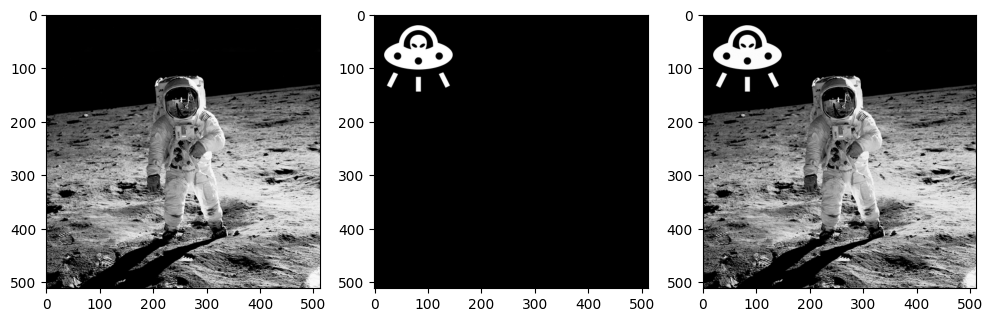

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(buzz_gray, cmap='gray')
ax[1].imshow(alien_gray, cmap='gray')
ax[2].imshow(buzz_alien_gray, cmap='gray')

**Image subtraction**

$$
f(m,n) = f_1(m,n) - f_2(m,n)
$$

- Example: detect changes between two images

In [4]:
cat1_rgb = skimage.util.img_as_float(skimage.io.imread('../data/cat_left.png'))
cat2_rgb = skimage.util.img_as_float(skimage.io.imread('../data/cat_right.png'))
cat_diff_rgb = np.abs(cat1_rgb - cat2_rgb)

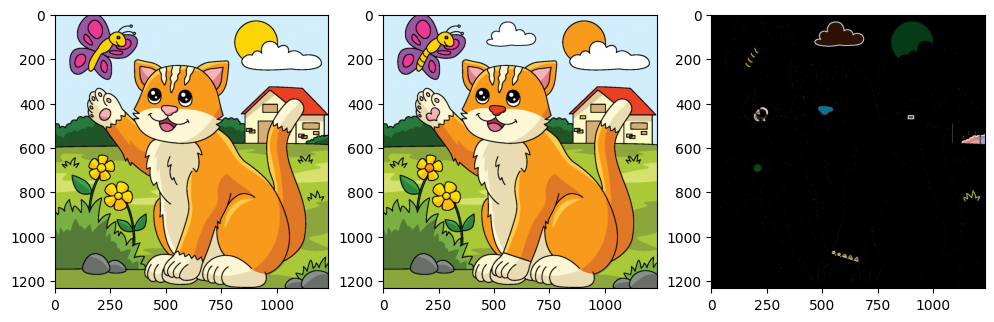

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(cat1_rgb, cmap='gray')
ax[1].imshow(cat2_rgb, cmap='gray')
ax[2].imshow(cat_diff_rgb, cmap='gray');

**Image division**

$$
f(m,n) = \frac{f_1(m,n)}{f_2(m,n)}
$$

- Example: correct non-homogeneous illumination

In [6]:
coins_non_uniform_gray = skimage.io.imread('../data/coins_non_uniform.png', as_gray=True)
coins_bg_gray = skimage.io.imread('../data/coins_background.png', as_gray=True)
coins_uniform_gray = coins_non_uniform_gray / coins_bg_gray

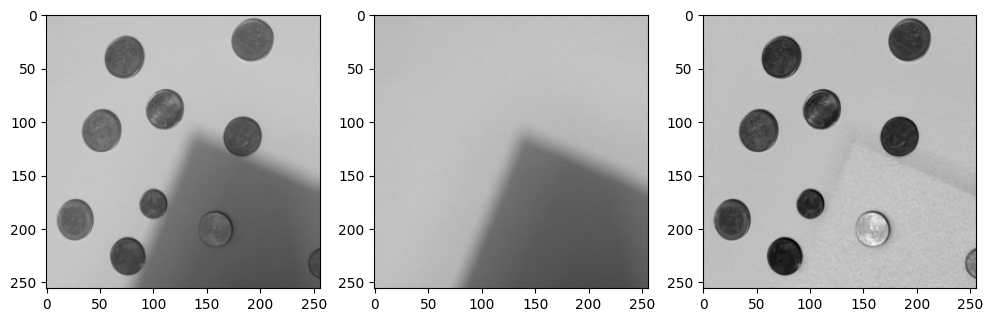

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(coins_non_uniform_gray, cmap='gray', vmin=0., vmax=255)
ax[1].imshow(coins_bg_gray, cmap='gray', vmin=0., vmax=255)
ax[2].imshow(coins_uniform_gray, cmap='gray');

# Popular image file formats

<figure class="image">
  <img src="../figures/digital_images-raster_vs_svg.png" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://en.wikipedia.org/wiki/SVG">Wikipedia</a></figcaption>
</figure>

**Bitmap (BMP)**
- Raster graphics file
- Supports grayscale, indexed and true color images
- Basic Run Length Encoding (RLE) compression

**Graphics Interchange Format (GIF)**
- Raster graphics file
- Supports indexed color at multiple depths, interlaced image loading
- Lossless Lempel-Ziv-Welsch (LZW) compression
- Can store multiple images in a single file and animate
- Popular on the web

**Portable Network Graphics (PNG)**
- Raster graphics file
- Supports up to $3 \times 16$ bit per pixel, indexed color images, alpha channel
- Up to $2^{30} \times 2^{30}$ pixels
- Lossless Phil Katz's ZIP (PKZIP) compression
- Should be the default choice for lossless images

**Tagged Image File Format (TIFF)**
- Raster graphics file
- Flexible file format designed to meet the professional needs of diverse fields
- Supports large integer depth and floating point pixels
- Supports both lossless (LZW, ZIP, CCIT) and lossy compression (JPEG)
- Multiple images in single file (pages)
- Supports arbitrary metadata

**JPEG File Interchange Format (JFIF)**
- Joint Photography Experts Group (JPEG)
- Raster graphics file
- Lossy compression based on Discrete Cosine Transform (DCT), Huffman coding and RLE
- Compression about 1 bit per pixel

**Scalable Vector Graphics (SVG)**
- Vector graphics file
- Represented as XML that defines 14 (SVG 1.1) functional areas and feature sets (e.g. paths, shapes, text, etc.)
- Supports interactivity, animation, and rich graphical capabilities, making it suitable for both web and print applications
- Can have raster image inside
- Lossless compression (GZIP)

# Image histogram

**What is a histogram?**
- Histogram in general is a frequency distribution.
- It tells us how many pixels of each intensity there are in a given image.
- In case of an 8-bit integer grayscale image with values in the range $[0, 255]$, i.e. with 256 unique values, each single histogram entry is defined as
  $$
  h_f(i) = \textrm{the number of pixels in }f\textrm{ with the intensity }i
  $$
- We can represent the histogram for example as a vector of 256 values.

<figure class="image">
  <img src="../figures/digital_images-histogram.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 2.3</figcaption>
</figure>

**Histogram and image exposure**
- Histogram tells us e.g. about the image exposure (~resulting brightness), see following figure:
<figure class="image">
  <img src="../figures/digital_images-histogram_exposure.png" alt="" style="width: 6.4in;"/>
  <figcaption>(a) Under-exposure, (b) correct exposure, (c) over-exposure<br>Source: [Burger22], Fig. 2.6</figcaption>
</figure>

**Histogram and contrast**
- Contrast corresponds to the range of intensity values effectively used in an image.
<figure class="image">
  <img src="../figures/digital_images-histogram_contrast.png" alt="" style="width: 6.4in;"/>
  <figcaption>(a) Low contrast (small range of values), (b) normal constrast, (c) high contrast<br>Source: [Burger22], Fig. 2.7</figcaption>
</figure>

**Histogram and dynamic range**
- Dynamic range corresponds to the number of distinct intensity values used in an image.
<figure class="image">
  <img src="../figures/digital_images-histogram_dynamic_range.png" alt="" style="width: 6.4in;"/>
  <figcaption>(a) Under-exposure, (b) correct exposure, (c) over-exposure<br>Source: [Burger22], Fig. 2.6</figcaption>
</figure>

## Computing histogram

In [8]:
def histogram_uint8(gray: np.ndarray) -> np.ndarray:
    assert gray.dtype == np.uint8
    M, N = gray.shape
    
    # init to zeros
    h = np.zeros(256, dtype=int)

    for m in range(M):
        for n in range(N):
            # intensity at position (m, n)
            a = gray[m, n]
            # increment corresponding histogram entry by one
            h[a] += 1
    
    return h

In [9]:
engine_gray = skimage.util.img_as_ubyte(skimage.io.imread('../data/engine.jpg', as_gray=True))
engine_hist = histogram_uint8(engine_gray)
engine_hist.shape, engine_hist.dtype, engine_hist.min(), engine_hist.max()

((256,), dtype('int64'), np.int64(134), np.int64(14824))

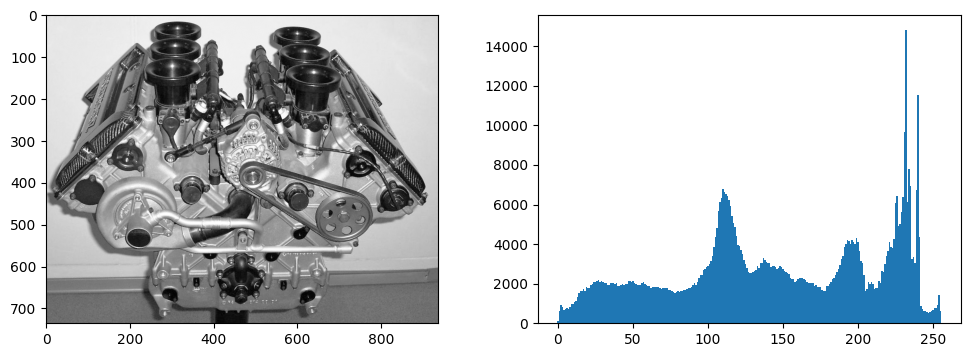

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(engine_gray, cmap='gray', vmin=0, vmax=255)
axes[1].bar(np.arange(256), engine_hist, width=1, ec='none');

In [11]:
xray_gray = skimage.util.img_as_ubyte(skimage.io.imread('../data/xray.png', as_gray=True))
xray_hist = histogram_uint8(xray_gray)
xray_hist.shape, xray_hist.dtype, xray_hist.min(), xray_hist.max()

((256,), dtype('int64'), np.int64(0), np.int64(10811))

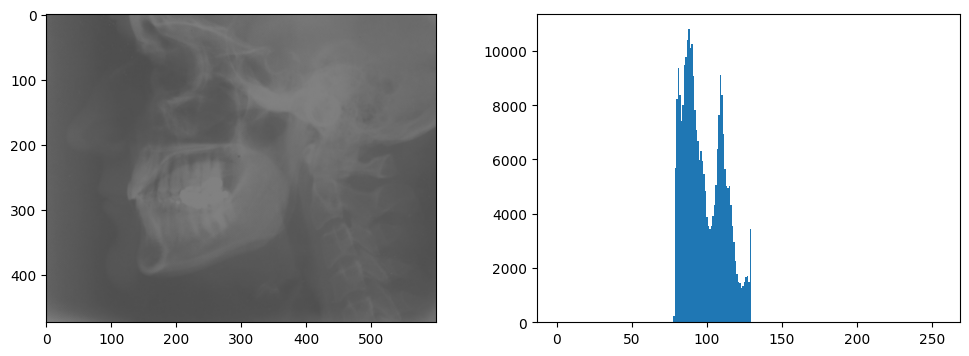

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(xray_gray, cmap='gray', vmin=0, vmax=255)
axes[1].bar(np.arange(256), xray_hist, width=1, ec='none');

## Histogram bins


- In case we have more too many unique intensities, e.g. when using `float` numeric precision with values in the range $[0, 1]$, it is not practical to have a separate histogram bin for each possible value.
- Instead, we can group ranges of intensities into common bins, i.e. each bin representing a range instead of a single intensity.
- This is often called *binning*.
- The histogram then will be
  $$
  h_f(i) = \text{the number of pixels in }f\text{ with intensity in the range }[a_i,a_{i+1})
  $$
  for $i = 0, \ldots, B-1$, where $B$ denotes the total number of intensity bins.

In [13]:
def histogram_binned(gray: np.ndarray, bins: tuple[float, float, int]) -> np.ndarray:
    M, N = gray.shape

    # init to zeros
    amin, amax, anum = bins
    h = np.zeros(anum, dtype=int)

    for m in range(M):
        for n in range(N):
            # intensity at position (m, n)
            a = gray[m, n]
            # calculate index of the bin
            i = int((a - amin) / (amax - anum) * anum)
            i = max(0, i)  # must be >= 0
            i = min(anum - 1, i)  # must be < inum
            # increment corresponding histogram entry by one
            h[i] += 1
    
    return h

In [14]:
engine_hist = histogram_binned(engine_gray, (0, 255, 10))
engine_hist.shape, engine_hist.dtype, engine_hist.min(), engine_hist.max()

((10,), dtype('int64'), np.int64(31197), np.int64(138297))

In [15]:
engine_hist

array([ 31197,  48692,  47536,  44605, 119123,  69840,  58057,  62363,
        69186, 138297])

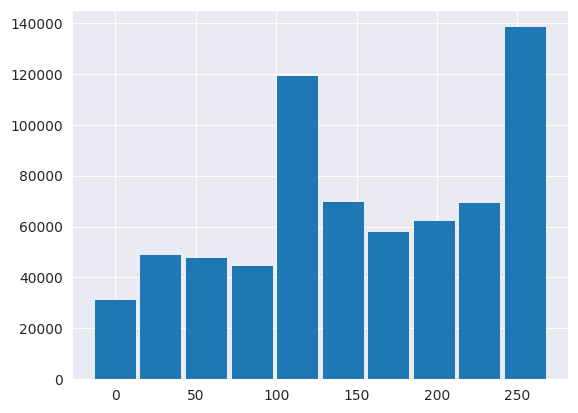

In [16]:
with sns.axes_style(style='darkgrid'):
    plt.bar(np.linspace(0, 255, 10), engine_hist, width=255/10, ec='none');

## Computing histogram in Numpy

`numpy.histogram`  
https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

In [17]:
engine_hist, bins = np.histogram(engine_gray, bins=np.arange(257))
engine_hist.shape, engine_hist.dtype, engine_hist.min(), engine_hist.max()

((256,), dtype('int64'), np.int64(134), np.int64(14824))

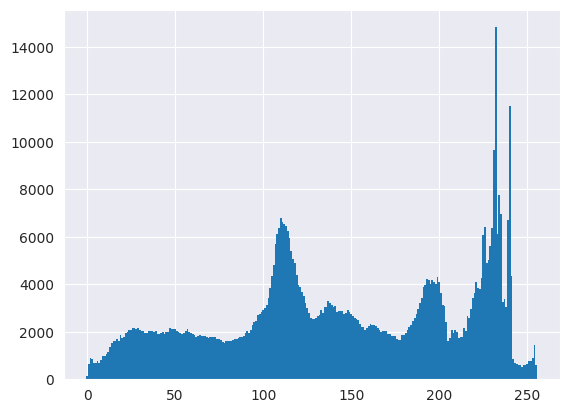

In [18]:
with sns.axes_style(style='darkgrid'):
    plt.bar(bins[:256], engine_hist, width=1, ec='none');

## Computing histogram in Matplotlib

`matplotlib.pyplot.hist`  
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

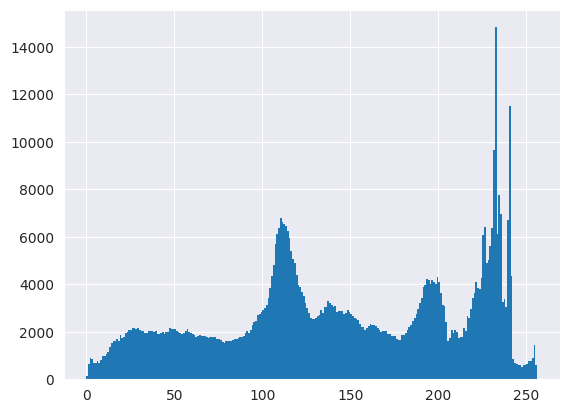

In [19]:
with sns.axes_style(style='darkgrid'):
    plt.hist(engine_gray.ravel(), bins=np.arange(257), width=1, ec='none');